## Network measures

### Local structures

**Indegree**
This is mostly a function of how Wikipedians revised the document and should largely be uniform across pages. The large values are likely pages with 'lists' of links.

**Outdegree**
This is 1st-order measure of an idea's influence.

### Mesoscale structures

**Clustering**
These look equally clustered among the topics.

**Centrality**
This reveals the distribution of sources of ideas within a field.

**Path lengths**

**Rich-club coefficient**

**Modularity**

**Controllability**
This is an nth-order measure of influence.

**Observability**
This is an nth-order measure of the inverse of influence.

**Coreness**
It seems that the more focused a topic is on a subtopic, the stronger the coreness. For example, genetics is heavily focused on DNA, and so it has high coreness. At the same time, in the field of economics, the concept of "economics" has high degree. Yet, it has low coreness because the field itself is heterogeneous, with major subfields such as "macroeconomics" and "microeconomics".

**Characteristic path length**
I'm not sure what path length reveals. Perhaps it is a measure of the heterogeneity in research? It describes how far one idea is to another, topologically. Cognitive science and earth science have ideas that are far away.

In [1]:
%load_ext autoreload
%autoreload 2
import os,sys
sys.path.insert(1, os.path.join(sys.path[0], '..', 'module'))

### Load networks

In [5]:
topics = ['anatomy', 'biochemistry', 'cognitive science', 'evolutionary biology',
          'genetics', 'immunology', 'molecular biology']
topics += ['chemistry', 'biophysics', 'energy', 'optics', 
           'earth science', 'geology', 'meteorology']
topics += ['philosophy of language', 'philosophy of law', 
           'philosophy of mind', 'philosophy of science']
topics += ['economics', 'accounting', 'education', 'linguistics', 'law', 'psychology', 'sociology']
topics += ['electronics', 'software engineering', 'robotics']
topics += ['physics']

In [8]:
import wiki

path_saved = '/Users/harangju/Box Sync/Research/my papers/wikipedia/data/graphs/dated/'
networks = {}
for topic in topics:
    networks[topic] = wiki.Net()
    networks[topic].load_graph(path_saved + topic + '.gexf')
networks

{'anatomy': <wiki.Net at 0x7fda0176dac8>,
 'biochemistry': <wiki.Net at 0x7fda12339080>,
 'cognitive science': <wiki.Net at 0x7fda1232a0b8>,
 'evolutionary biology': <wiki.Net at 0x7fda53630080>,
 'genetics': <wiki.Net at 0x7fda53630390>,
 'immunology': <wiki.Net at 0x7fda53630748>,
 'molecular biology': <wiki.Net at 0x7fda53630908>,
 'chemistry': <wiki.Net at 0x7fda536302b0>,
 'biophysics': <wiki.Net at 0x7fda124736d8>,
 'energy': <wiki.Net at 0x7fda124739e8>,
 'optics': <wiki.Net at 0x7fda12473c18>,
 'earth science': <wiki.Net at 0x7fda534e5ef0>,
 'geology': <wiki.Net at 0x7fda533630f0>,
 'meteorology': <wiki.Net at 0x7fda5333c208>,
 'philosophy of language': <wiki.Net at 0x7fda535b0198>,
 'philosophy of law': <wiki.Net at 0x7fda535b09b0>,
 'philosophy of mind': <wiki.Net at 0x7fda535b0e48>,
 'philosophy of science': <wiki.Net at 0x7fda535b0cc0>,
 'economics': <wiki.Net at 0x7fda535b0c50>,
 'accounting': <wiki.Net at 0x7fda12324588>,
 'education': <wiki.Net at 0x7fda01666828>,
 'ling

### Generate null networks

Build into the `Net` class?

### Run analysis

In [ ]:
import numpy as np
import networkx.algorithms as nxalg
import bct

stats = {}
for topic, graph in graphs.items():
    print('Topic: ' + topic)
    am = nx.convert_matrix.to_numpy_array(graph)
    stats[topic] = {'indegree': {'values': [d[1] for d in graph.in_degree]},
                    'outdegree': {'values': [d[1] for d in graph.out_degree]},
                    'clustering': {'values': 
                                   list(nxalg.cluster.clustering(graph).values())},
                    'centrality': {'values': 
                                   list(nxalg.betweenness_centrality(graph).values())},
                    'coreness': {'values': bct.core_periphery_dir(am)[1]},
                    'path length': {'values': [y for x in list(nx.shortest_path_length(graph))
                                               for y in list(x[1].values())]},
                    'char path length': {'values': bct.charpath(am)[0]}}

#### Run analysis on MATLAB

In [ ]:
import scipy.io as sio

path = '/Users/harangju/Developer/data/wiki/graphs/'
for topic, graph in graphs.items():
    x = nx.convert_matrix.to_numpy_array(graph)
    sio.savemat(path + topic + '.mat', {'X': x})

In [220]:
ex_graph = nx.DiGraph()
ex_graph.add_edge(0,1)
ex_graph.add_edge(2,2)
ex_graph.add_edge(3,4)
nx.convert_matrix.to_numpy_array(ex_graph)

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0.]])

converting to numpy is row-to-column

In [274]:
metrics = sio.loadmat(path + 'metrics.mat')
for i in range(len(metrics['topics'][0])):
    topic = metrics['topics'][0][i][0]
    stats[topic]['rich club'] = {'values': [x for x in metrics['rich'][0][i][0] 
                                            if not np.isnan(x)]}
    stats[topic]['modularity'] = {'values': [x[0] for x in metrics['mod'][0][i]]}
    stats[topic]['controllability'] = {'values': [x[0] for x in metrics['cont'][0][i]]}
    stats[topic]['observability'] = {'values': [x[0] for x in metrics['obs'][0][i]]}

In [275]:
for topic in stats.keys():
    for stat in stats[topic].keys():
        if 'values' in stats[topic][stat].keys():
            stats[topic][stat]['mean'] = np.mean(stats[topic][stat]['values'])
            stats[topic][stat]['std'] = np.std(stats[topic][stat]['values'])

/anaconda3/envs/wikinet/lib/python3.7/site-packages/numpy/core/_methods.py:117: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


### Display results

In [276]:
import pandas

mean = {}
for k, v in stats.items():
    mean[k] = {}
    for kk, vv in v.items():
        mean[k][kk] = vv['mean']
pandas.DataFrame(mean).transpose()

,indegree,outdegree,clustering,centrality,coreness,path length,char path length,rich club,modularity,controllability,observability
anatomy,3.619661,3.619661,0.097954,0.001512,0.737638,6.333171,0.002113,0.115980,0.604342,1.001692,1.001692
biochemistry,4.508869,4.508869,0.096448,0.001708,0.796979,4.279866,0.004946,0.211186,0.478762,1.001843,1.001843
cognitive science,2.750000,2.750000,0.165694,0.008716,0.753184,3.090568,0.026970,0.339975,0.428808,1.005851,1.005851
evolutionary biology,3.418803,3.418803,0.127987,0.004773,0.771078,3.879429,0.014343,0.365470,0.407169,1.002203,1.002203
genetics,3.811458,3.811458,0.092073,0.001483,0.875016,4.987032,0.003926,inf,0.498293,1.000889,1.000889
immunology,2.238095,2.238095,0.117715,0.001913,0.828653,4.329856,0.005747,0.279958,0.530708,1.001612,1.001612
molecular biology,3.191617,3.191617,0.103677,0.002207,0.744927,4.401425,0.009396,inf,0.477176,1.000954,1.000953
chemistry,5.779268,5.779268,0.111526,0.002100,0.729179,4.312141,0.007022,0.242642,0.462795,1.001251,1.001251
biophysics,1.519231,1.519231,0.066331,0.000897,0.753527,4.638013,0.004720,0.266737,0.695900,1.001853,1.001853
energy,1.651786,1.651786,0.112055,0.000664,0.745879,1.880531,0.014640,0.371056,0.519967,1.000400,1.000400


### Plot

* nice plots [seaborn](https://seaborn.pydata.org/examples/index.html)
* interactive [Bokeh](https://bokeh.pydata.org/en/latest/docs/gallery.html#gallery)

In [206]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style='whitegrid')

def plot_violin(data, xlabels, title, save_dir=None):
    f, ax = plt.subplots(figsize=(30, 6))
    data = [x[stat]['values'] for x in stats.values()]
    sns.violinplot(data=data)
    plt.xticks(np.arange(len(stats)), xlabels, rotation='vertical', fontsize=24)
    plt.yticks(fontsize=24)
    plt.title(title, fontsize=36)
    plt.subplots_adjust(bottom=0.2)
    sns.despine(left=True, bottom=True)
    if save_dir:
        plt.savefig(save_dir, dpi=300)
    return f, ax

def scatter(data, xlabels, title, save_dir=None):
    f, ax = plt.subplots(figsize=(30, 6))
    sns.scatterplot(x=np.arange(len(stats)), y=data, marker='x', s=100)
    plt.xticks(np.arange(len(stats)), xlabels, rotation='vertical', fontsize=24)
    plt.yticks(fontsize=24)
    plt.title(title, fontsize=24)
    sns.despine(left=True, bottom=True)
    if save_dir:
        plt.savefig(path_saved + stat, dpi=300)

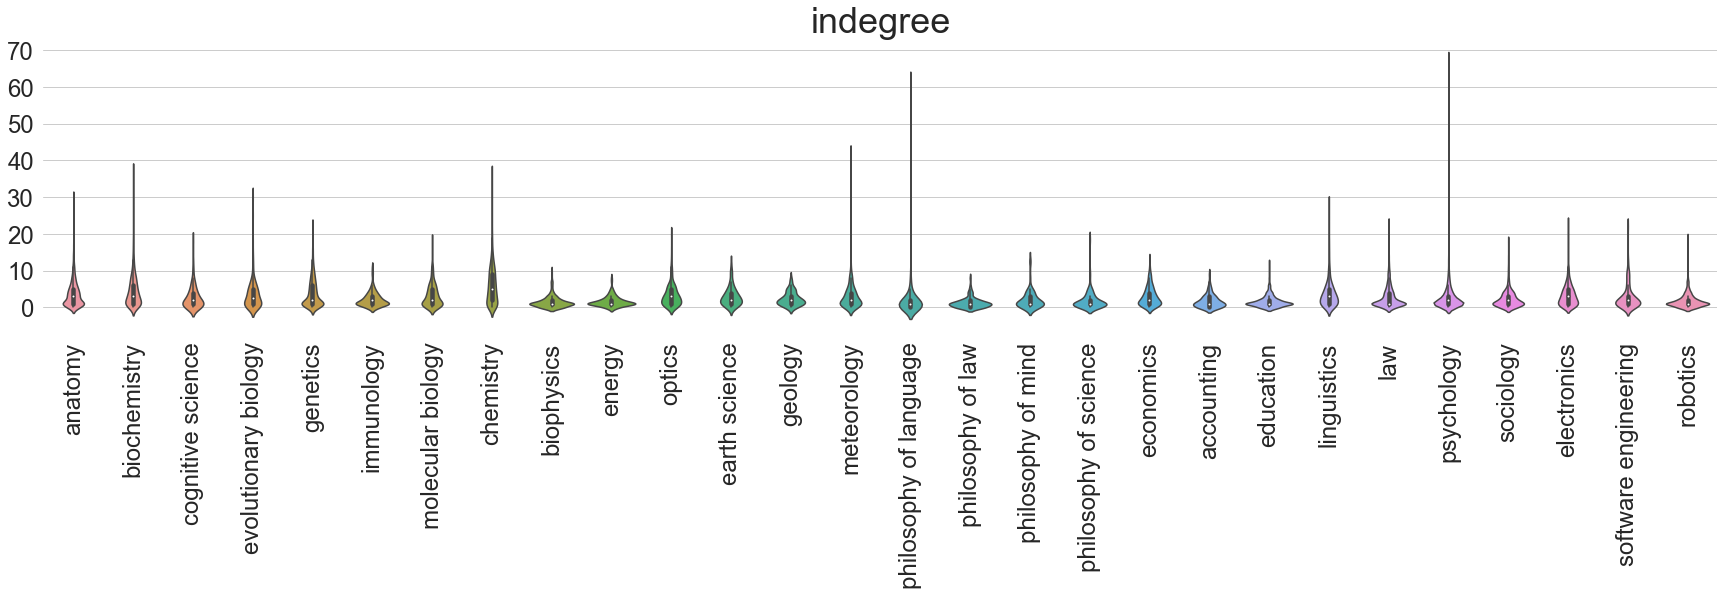

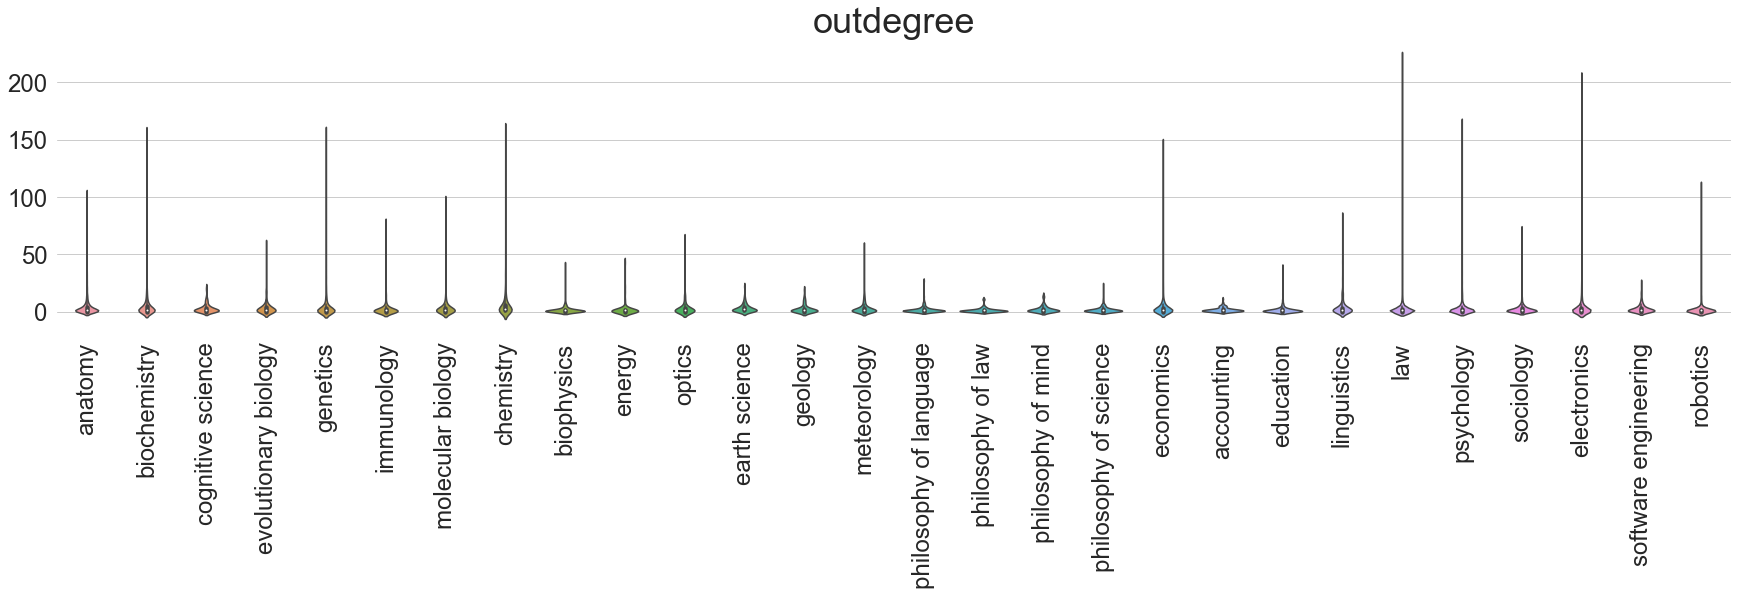

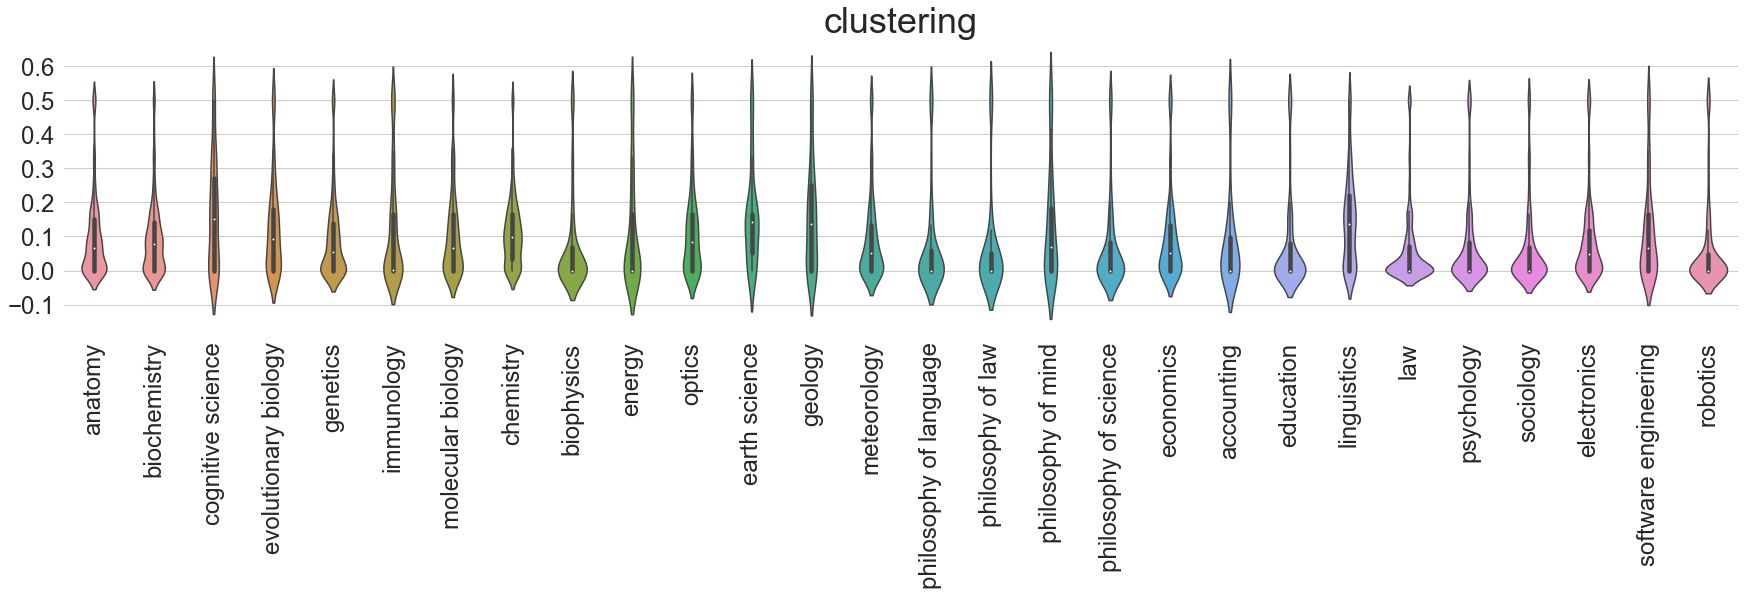

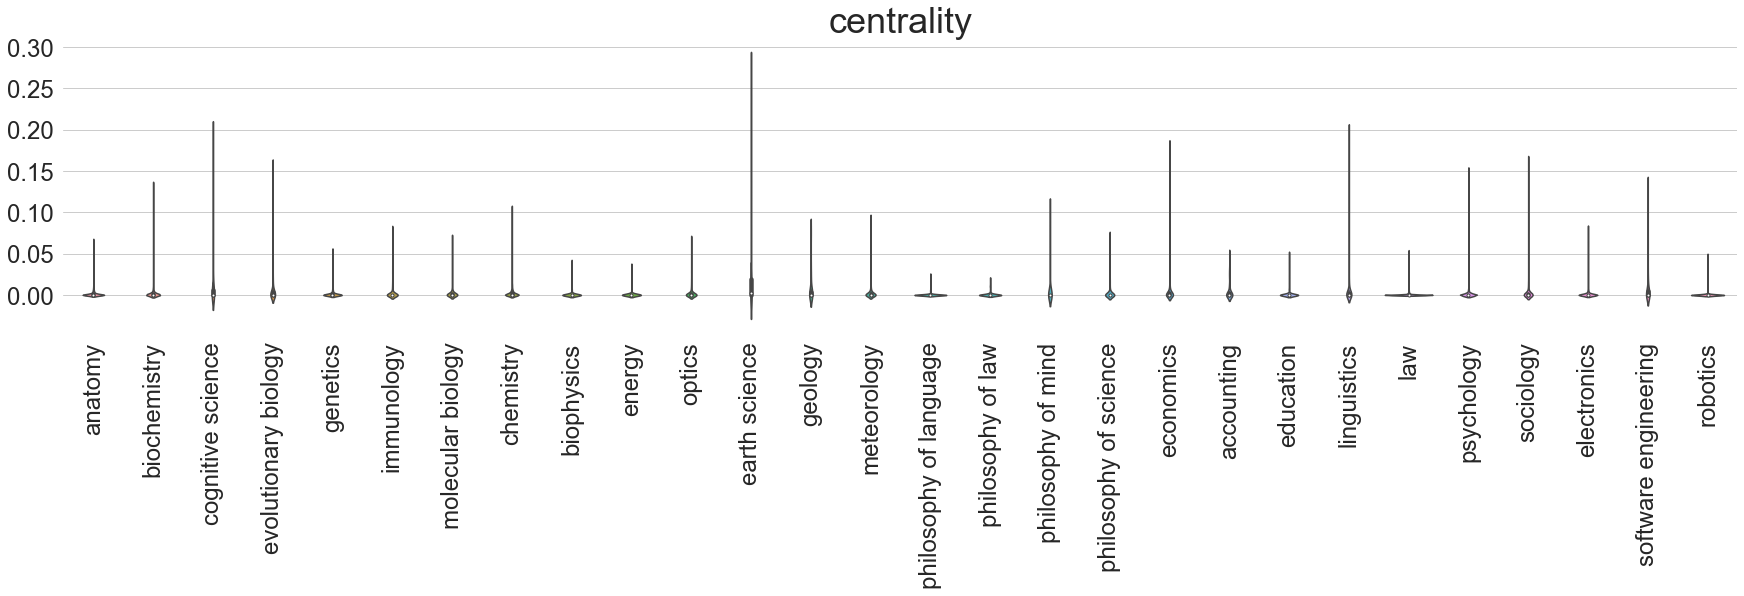

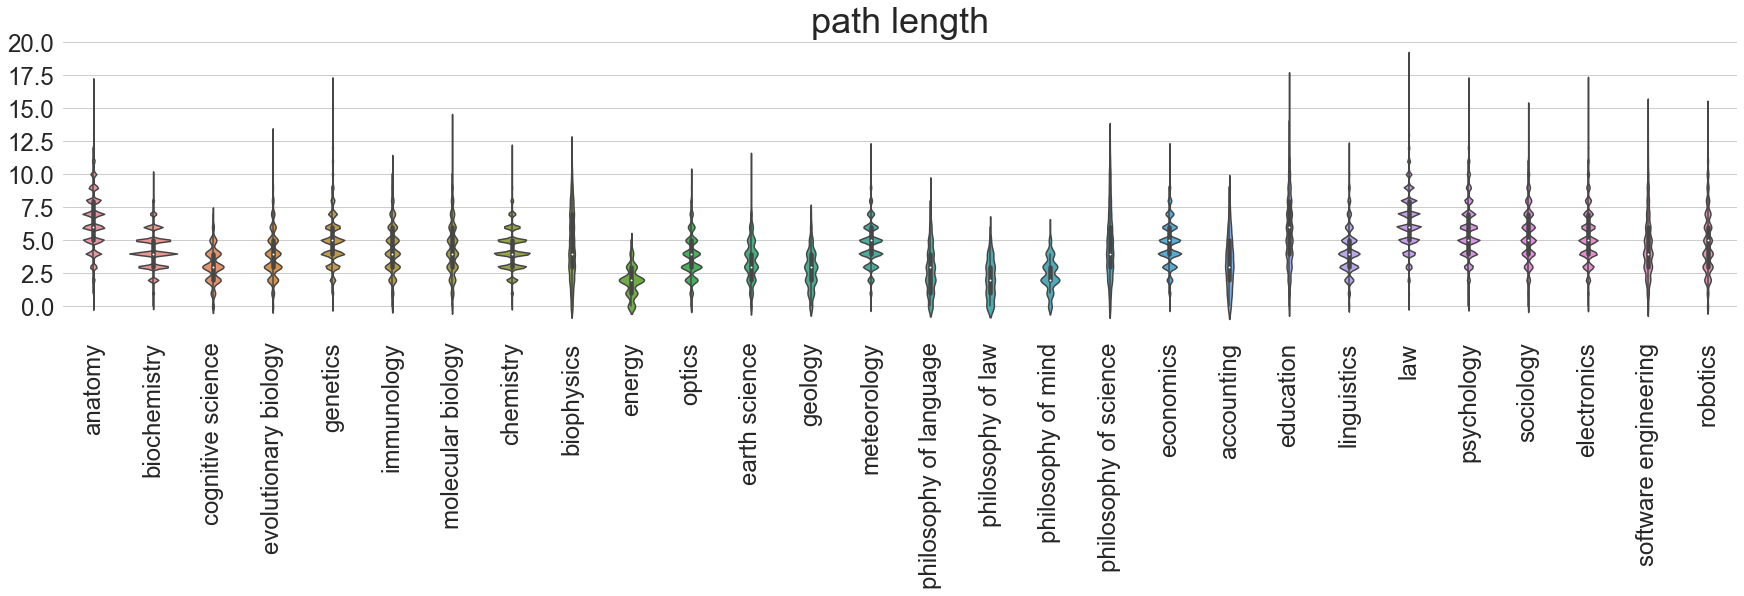

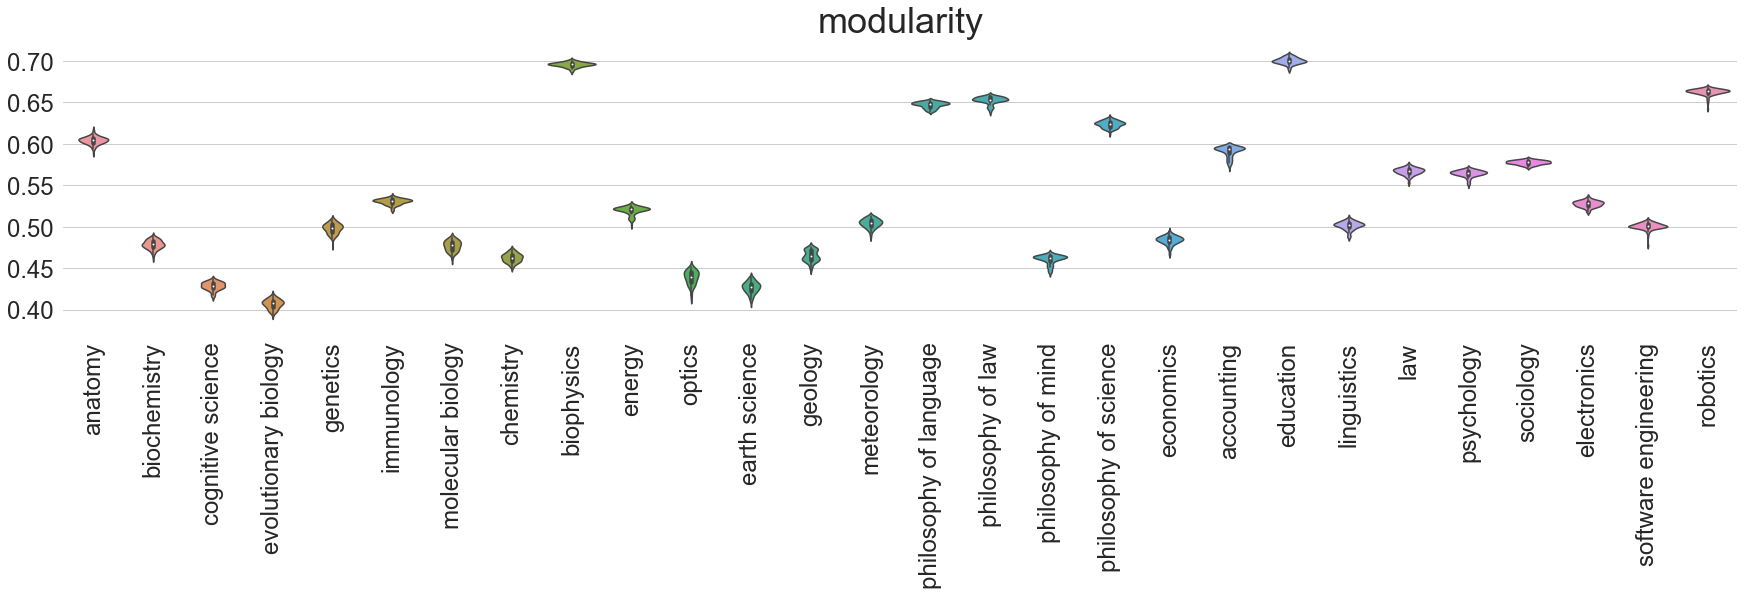

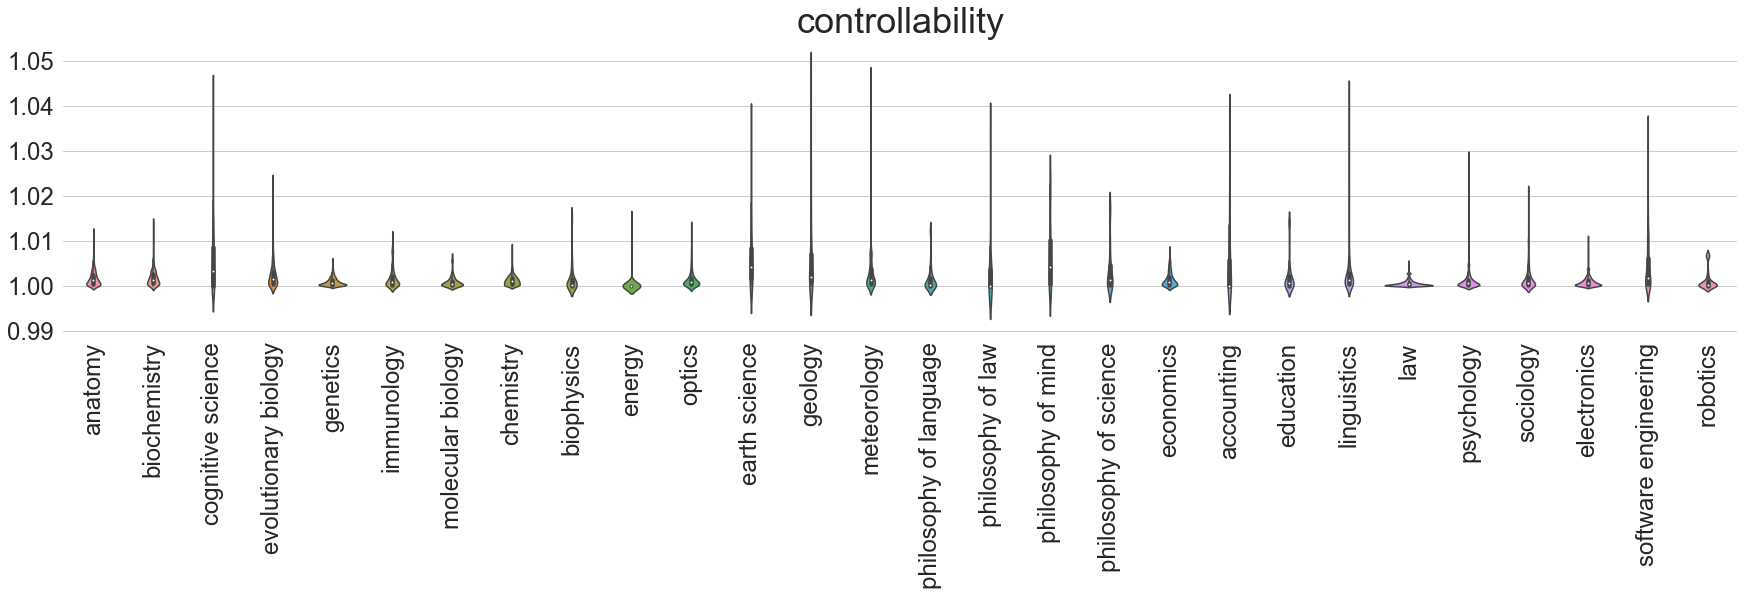

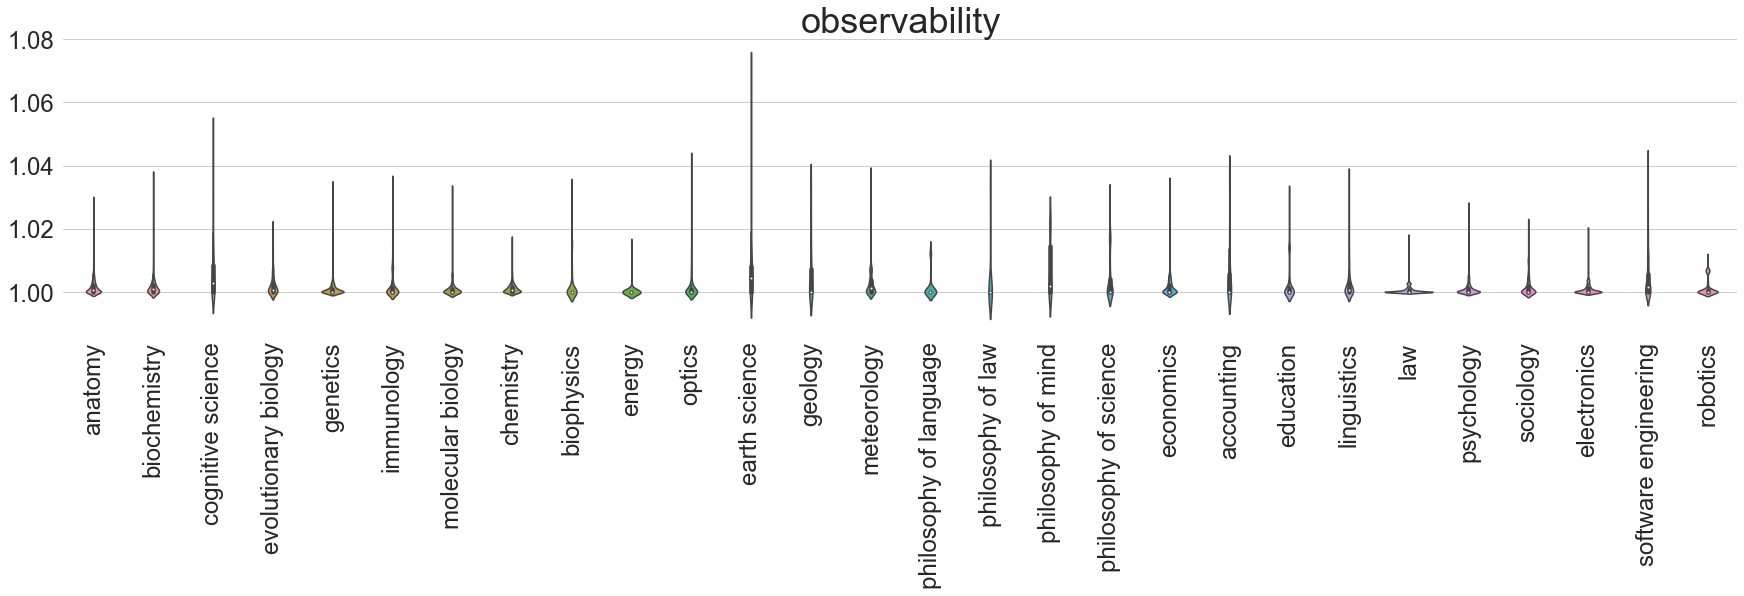

In [279]:
for stat in ['indegree', 'outdegree', 'clustering', 'centrality', 'path length', #'rich club', 
             'modularity', 'controllability', 'observability']:
    data = [x[stat]['values'] for x in stats.values()]
    plot_violin(data, stats.keys(), stat)

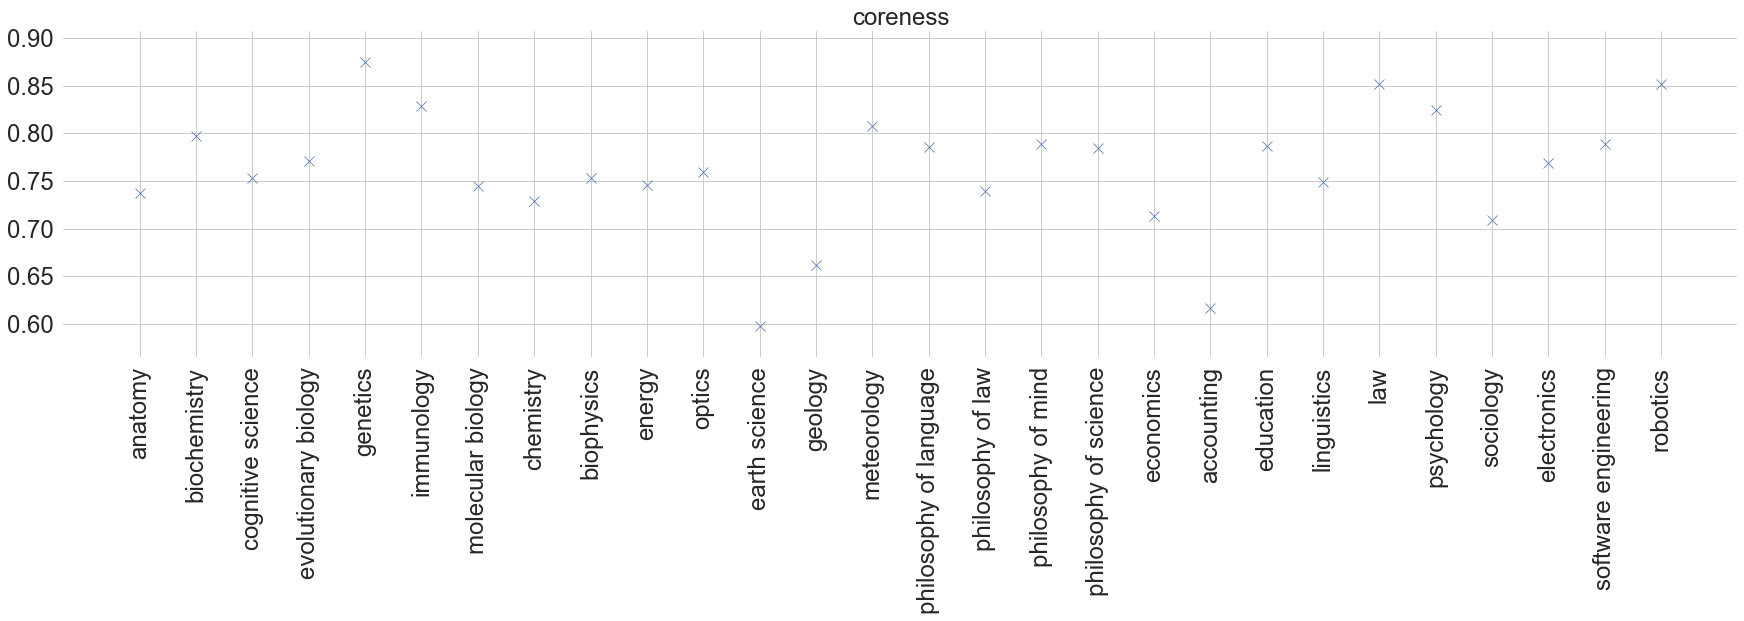

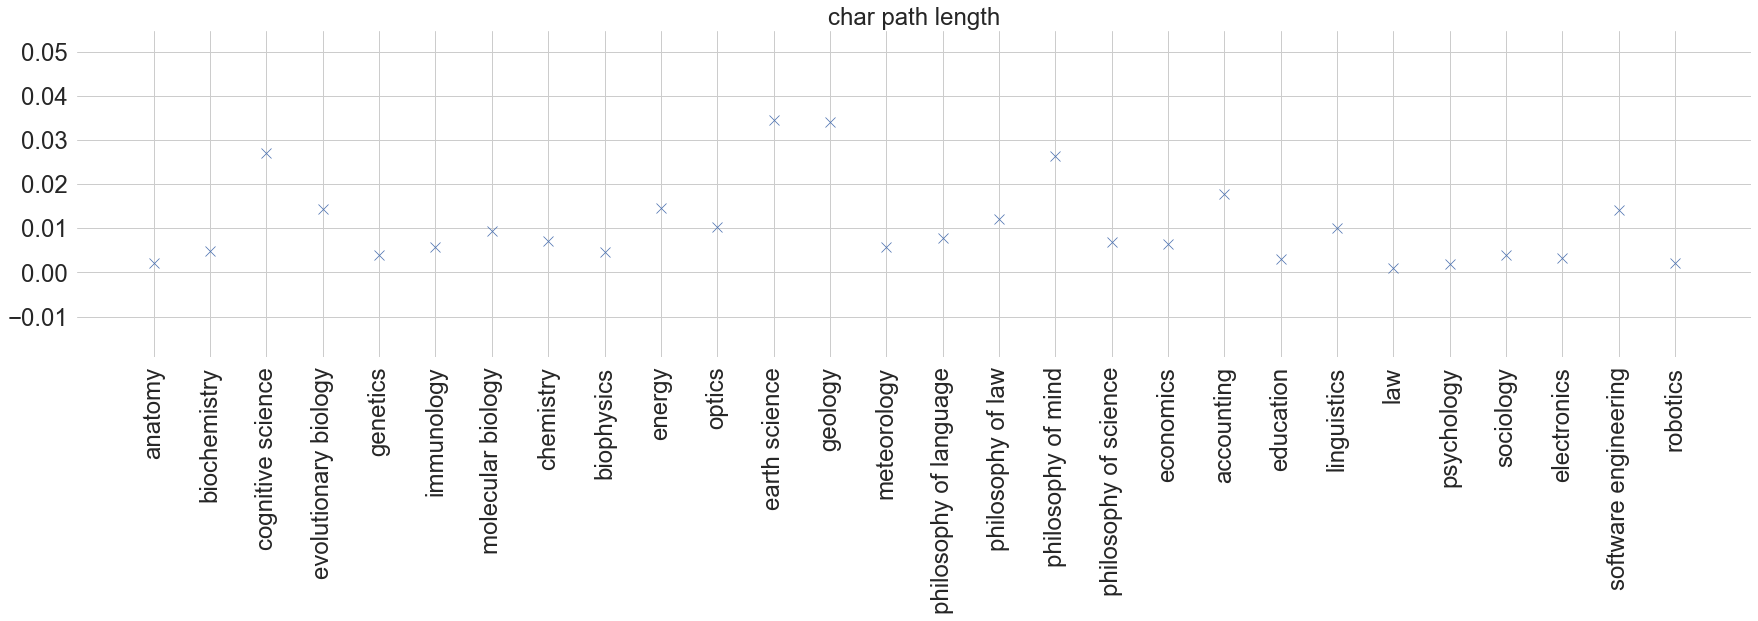

In [209]:
for stat in ['coreness', 'char path length']:
    data = [x[stat]['values'] for x in stats.values()]
    scatter(data, stats.keys(), stat)

In [ ]:
# plot actual vs null

### Measures in growing networks